# Advanced Retrieval with LangChain

In the following notebook, we'll explore various methods of advanced retrieval using LangChain!

We'll touch on:

- Naive Retrieval
- Best-Matching 25 (BM25)
- Multi-Query Retrieval
- Parent-Document Retrieval
- Contextual Compression (a.k.a. Rerank)
- Ensemble Retrieval
- Semantic chunking

We'll also discuss how these methods impact performance on our set of documents with a simple RAG chain.

There will be two breakout rooms:

- 🤝 Breakout Room Part #1
  - Task 1: Getting Dependencies!
  - Task 2: Data Collection and Preparation
  - Task 3: Setting Up QDrant!
  - Task 4-10: Retrieval Strategies
- 🤝 Breakout Room Part #2
  - Activity: Evaluate with Ragas

# 🤝 Breakout Room Part #1

## Task 1: Getting Dependencies!

We're going to need a few specific LangChain community packages, like OpenAI (for our [LLM](https://platform.openai.com/docs/models) and [Embedding Model](https://platform.openai.com/docs/guides/embeddings)) and Cohere (for our [Reranker](https://cohere.com/rerank)).

We'll also provide our OpenAI key, as well as our Cohere API key.

In [1]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API Key:")

In [25]:
os.environ["COHERE_API_KEY"] = getpass.getpass("Cohere API Key:")

## Task 2: Data Collection and Preparation

We'll be using our Loan Data once again - this time the strutured data available through the CSV!

### Data Preparation

We want to make sure all our documents have the relevant metadata for the various retrieval strategies we're going to be applying today.

In [2]:
from langchain_community.document_loaders.csv_loader import CSVLoader
from datetime import datetime, timedelta

loader = CSVLoader(
    file_path=f"./data/complaints.csv",
    metadata_columns=[
      "Date received", 
      "Product", 
      "Sub-product", 
      "Issue", 
      "Sub-issue", 
      "Consumer complaint narrative", 
      "Company public response", 
      "Company", 
      "State", 
      "ZIP code", 
      "Tags", 
      "Consumer consent provided?", 
      "Submitted via", 
      "Date sent to company", 
      "Company response to consumer", 
      "Timely response?", 
      "Consumer disputed?", 
      "Complaint ID"
    ]
)

loan_complaint_data = loader.load()

for doc in loan_complaint_data:
    doc.page_content = doc.metadata["Consumer complaint narrative"]

Let's look at an example document to see if everything worked as expected!

In [3]:
loan_complaint_data[0]

Document(metadata={'source': './data/complaints.csv', 'row': 0, 'Date received': '03/27/25', 'Product': 'Student loan', 'Sub-product': 'Federal student loan servicing', 'Issue': 'Dealing with your lender or servicer', 'Sub-issue': 'Trouble with how payments are being handled', 'Consumer complaint narrative': "The federal student loan COVID-19 forbearance program ended in XX/XX/XXXX. However, payments were not re-amortized on my federal student loans currently serviced by Nelnet until very recently. The new payment amount that is effective starting with the XX/XX/XXXX payment will nearly double my payment from {$180.00} per month to {$360.00} per month. I'm fortunate that my current financial position allows me to be able to handle the increased payment amount, but I am sure there are likely many borrowers who are not in the same position. The re-amortization should have occurred once the forbearance ended to reduce the impact to borrowers.", 'Company public response': 'None', 'Company'

## Task 3: Setting up QDrant!

Now that we have our documents, let's create a QDrant VectorStore with the collection name "LoanComplaints".

We'll leverage OpenAI's [`text-embedding-3-small`](https://openai.com/blog/new-embedding-models-and-api-updates) because it's a very powerful (and low-cost) embedding model.

> NOTE: We'll be creating additional vectorstores where necessary, but this pattern is still extremely useful.

In [4]:
from langchain_community.vectorstores import Qdrant
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

vectorstore = Qdrant.from_documents(
    loan_complaint_data,
    embeddings,
    location=":memory:",
    collection_name="LoanComplaints"
)

## Task 4: Naive RAG Chain

Since we're focusing on the "R" in RAG today - we'll create our Retriever first.

### R - Retrieval

This naive retriever will simply look at each review as a document, and use cosine-similarity to fetch the 10 most relevant documents.

> NOTE: We're choosing `10` as our `k` here to provide enough documents for our reranking process later

In [5]:
naive_retriever = vectorstore.as_retriever(search_kwargs={"k" : 10})

### A - Augmented

We're going to go with a standard prompt for our simple RAG chain today! Nothing fancy here, we want this to mostly be about the Retrieval process.

In [6]:
from langchain_core.prompts import ChatPromptTemplate

RAG_TEMPLATE = """\
You are a helpful and kind assistant. Use the context provided below to answer the question.

If you do not know the answer, or are unsure, say you don't know.

Query:
{question}

Context:
{context}
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_TEMPLATE)

### G - Generation

We're going to leverage `gpt-4.1-nano` as our LLM today, as - again - we want this to largely be about the Retrieval process.

In [7]:
from langchain_openai import ChatOpenAI

chat_model = ChatOpenAI(model="gpt-4.1-nano")

### LCEL RAG Chain

We're going to use LCEL to construct our chain.

> NOTE: This chain will be exactly the same across the various examples with the exception of our Retriever!

In [8]:
from langchain_core.runnables import RunnablePassthrough
from operator import itemgetter
from langchain_core.output_parsers import StrOutputParser

naive_retrieval_chain = (
    # INVOKE CHAIN WITH: {"question" : "<<SOME USER QUESTION>>"}
    # "question" : populated by getting the value of the "question" key
    # "context"  : populated by getting the value of the "question" key and chaining it into the base_retriever
    {"context": itemgetter("question") | naive_retriever, "question": itemgetter("question")}
    # "context"  : is assigned to a RunnablePassthrough object (will not be called or considered in the next step)
    #              by getting the value of the "context" key from the previous step
    | RunnablePassthrough.assign(context=itemgetter("context"))
    # "response" : the "context" and "question" values are used to format our prompt object and then piped
    #              into the LLM and stored in a key called "response"
    # "context"  : populated by getting the value of the "context" key from the previous step
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's see how this simple chain does on a few different prompts.

> NOTE: You might think that we've cherry picked prompts that showcase the individual skill of each of the retrieval strategies - you'd be correct!

In [9]:
naive_retrieval_chain.invoke({"question" : "What is the most common issue with loans?"})["response"].content

'Based on the provided context, the most common issues with loans appear to be related to:\n\n- Errors or discrepancies in loan balances and statuses (e.g., incorrect reporting of loan balances, statuses, or account information).\n- Problems with how payments are being handled, such as difficulties applying payments correctly or the accumulation of interest due to payment arrangements.\n- Communication issues and lack of transparency from servicers, including not informing borrowers about changes in loan servicers, transfer of loans, or updates on account status.\n- Disputes over interest rates, increased balances, and fees not aligned with original loan terms.\n- Mishandling of personal information and privacy violations.\n\nAmong these, a recurring theme is **errors or inaccuracies in loan information and how they are managed or reported**, which leads to financial hardships and frustration for borrowers. This aligns with the common complaint about mistakes in loan balances, account 

In [10]:
naive_retrieval_chain.invoke({"question" : "Did any complaints not get handled in a timely manner?"})["response"].content

'Yes, based on the provided complaints, there are several instances where complaints were not handled in a timely manner. Specifically, at least two complaints explicitly mention that responses or resolutions took longer than expected:\n\n1. Complaint received on 03/28/25 (Complaint ID: 12709087) by MOHELA states that the response was "Not in time" ("Timely response?": "No").\n2. Complaint received on 04/21/25 (Complaint ID: 13062402) by Nelnet, Inc. indicates that the response was "Yes" in timely manner, but the complaint itself involves delays in correcting inaccurate credit report information—though the response was timely, the issue persisted for a lengthy period.\n\nFurthermore, several other complaints describe ongoing issues that remained unresolved for weeks or months, indicating delays in handling or resolution. For example, complaints about unresolved loan corrections, missing payments, or reports of harassment suggest that some complaints were not addressed promptly.\n\nIn s

In [11]:
naive_retrieval_chain.invoke({"question" : "Why did people fail to pay back their loans?"})["response"].content

'People failed to pay back their loans primarily due to a combination of factors including:\n\n1. **Lack of clear information and communication:** Borrowers often reported not being adequately informed about their repayment obligations, the start date of payments, or changes in their loan status. For example, some did not receive proper notifications about payment due dates or loan transfers between servicers.\n\n2. **Financial hardships and unaffordable payment options:** Many borrowers faced financial difficulties preventing them from making payments. Some could not afford increased monthly payments or additional expenses like basic living costs. Others were unable to qualify for forgiveness programs or manage accruing interest, which extended the repayment period and increased total debt.\n\n3. **Interest accumulation and loan management issues:** The continued accumulation of interest—especially when loans were in forbearance or deferment—often negated payments made, resulting in t

Overall, this is not bad! Let's see if we can make it better!

## Task 5: Best-Matching 25 (BM25) Retriever

Taking a step back in time - [BM25](https://www.nowpublishers.com/article/Details/INR-019) is based on [Bag-Of-Words](https://en.wikipedia.org/wiki/Bag-of-words_model) which is a sparse representation of text.

In essence, it's a way to compare how similar two pieces of text are based on the words they both contain.

This retriever is very straightforward to set-up! Let's see it happen down below!


In [12]:
from langchain_community.retrievers import BM25Retriever

bm25_retriever = BM25Retriever.from_documents(loan_complaint_data, )

We'll construct the same chain - only changing the retriever.

In [13]:
bm25_retrieval_chain = (
    {"context": itemgetter("question") | bm25_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's look at the responses!

In [14]:
bm25_retrieval_chain.invoke({"question" : "What is the most common issue with loans?"})["response"].content

'Based on the provided context, the most common issue with loans appears to be problems related to dealing with lenders or servicers, such as improper handling of payments, incorrect information about loan balances, or difficulties in managing repayment terms. Specifically, issues like not being able to pay the loan as intended, confusion over interest calculations, and disputes over loan information are prevalent.'

In [15]:
bm25_retrieval_chain.invoke({"question" : "Did any complaints not get handled in a timely manner?"})["response"].content

'Based on the provided information, all the complaints listed were responded to with a "Closed with explanation" status and are indicated as being "Timely responses." Therefore, it appears that no complaints went unhandled in a timely manner.'

In [16]:
bm25_retrieval_chain.invoke({"question" : "Why did people fail to pay back their loans?"})["response"].content

'People often fail to pay back their loans due to a variety of issues, including miscommunication with loan servicers, problems with payment plans, and administrative errors. In some cases, borrowers are unaware of transfer or changes in their loan accounts, such as being unenrolled from autopay without notification, or encountering errors that result in payments being reversed or reported as past due. Additionally, borrowers may face difficulties if loan servicers steer them into incorrect forbearance options, or if efforts to establish or modify payment plans are unresponded to or neglected. These issues can lead to negative impacts on credit scores and feelings of being deceived or disenfranchised, which ultimately hinder repayment.'

In [22]:
bm25_retrieval_chain.invoke({"question" : "find all complaints mentioning 'FDCPA'"})["response"].content

"The complaints mentioning 'FDCPA' are not present in the provided context."

In [23]:
naive_retrieval_chain.invoke({"question" : "find all complaints mentioning 'FDCPA'"})["response"].content

'The complaints mentioning \'FDCPA\' are as follows:\n\n1. Complaint at row 169:\n   - Narrative: "Formal Dispute of Inaccurate Information under FCRA and FDCPA Compliance I am writing to formally dispute inaccuracies in my credit report as per my rights under the Fair Credit Reporting Act ( FCRA ) and the Fair Debt Collection Practices Act ( FDCPA ). The following accounts contain erroneous, unverifiable, and misleading information that must be investigated and corrected immediately..."\n   - Company: EdFinancial Services\n\n2. Complaint at row 744:\n   - Narrative: "XXXX XXXX XXXX XXXX XXXX Consumer Financial Protection Bureau XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX Subject : FCRA Violation Dispute of Inaccurate Student Loan Reporting To Whom It May Concern, I am filing this formal complaint under the * * Fair Credit Reporting Act ( FCRA ) * * regarding inaccurate information being reported on my credit file..."\n   - Company: Maximus Federal Services, Inc.\n\n3. Complaint at ro

It's not clear that this is better or worse, if only we had a way to test this (SPOILERS: We do, the second half of the notebook will cover this)

<div style="background-color: #204B8E; color: white; padding: 10px; border-radius: 5px;">

#### ❓ Question #1:

Give an example query where BM25 is better than embeddings and justify your answer.

</div>

<div style="background-color: #204B8E; color: white; padding: 10px; border-radius: 5px;">
### Answer:

-Justification: BM25 excels because it efficiently finds documents containing the exact, rare keyword. It quickly scores and ranks complaints based on the explicit mention of that specific term. 

-1. Query: "find all complaints mentioning FDCPA"
-2. Query: "Get the details of Complaint ID 12709087?"
</div>

## Task 6: Contextual Compression (Using Reranking)

Contextual Compression is a fairly straightforward idea: We want to "compress" our retrieved context into just the most useful bits.

There are a few ways we can achieve this - but we're going to look at a specific example called reranking.

The basic idea here is this:

- We retrieve lots of documents that are very likely related to our query vector
- We "compress" those documents into a smaller set of *more* related documents using a reranking algorithm.

We'll be leveraging Cohere's Rerank model for our reranker today!

All we need to do is the following:

- Create a basic retriever
- Create a compressor (reranker, in this case)

That's it!

Let's see it in the code below!

In [26]:
from langchain.retrievers.contextual_compression import ContextualCompressionRetriever
from langchain_cohere import CohereRerank

compressor = CohereRerank(model="rerank-v3.5")
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=naive_retriever
)

Let's create our chain again, and see how this does!

In [27]:
contextual_compression_retrieval_chain = (
    {"context": itemgetter("question") | compression_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

In [28]:
contextual_compression_retrieval_chain.invoke({"question" : "What is the most common issue with loans?"})["response"].content

'Based on the provided context, one of the most common issues with loans, especially student loans, is dealing with the lender or servicer, which often includes receiving bad information about the loan, errors in loan balances, misapplied payments, wrongful denials of payment plans, or mishandling of the loan account. Additionally, issues related to managing repayment options, interest accumulation, and lack of clear information from servicers are frequent concerns among borrowers.'

In [29]:
contextual_compression_retrieval_chain.invoke({"question" : "Did any complaints not get handled in a timely manner?"})["response"].content

'Based on the provided information, there is evidence that some complaints did not get handled in a timely manner. For example, one complaint regarding account review and loan issues has been open for over 18 months without resolution, and another ongoing issue has persisted for 2-3 weeks without resolution. Additionally, there is a complaint about violations and unauthorized access that has not received response or follow-up. Although some responses from companies were marked as "Timely," the ongoing nature of certain issues suggests they were not resolved promptly or satisfactorily.'

In [31]:
contextual_compression_retrieval_chain.invoke({"question" : "Why did people fail to pay back their loans?"})["response"].content

'People failed to pay back their loans primarily due to factors such as a lack of clear communication and understanding about the repayment process, unanticipated or increased interest accumulation, and challenges related to managing payments. Specifically, some borrowers were not informed about their obligation to repay loans or about the details of accruing interest, especially when loans were transferred between servicers without proper notice. Additionally, options like forbearance or deferment, while accessible, often led to continued interest accumulation, making repayment more difficult over time. Financial hardships, stagnant wages, and the inability to increase payments further contributed to difficulties in paying back the loans.'

We'll need to rely on something like Ragas to help us get a better sense of how this is performing overall - but it "feels" better!

## Task 7: Multi-Query Retriever

Typically in RAG we have a single query - the one provided by the user.

What if we had....more than one query!

In essence, a Multi-Query Retriever works by:

1. Taking the original user query and creating `n` number of new user queries using an LLM.
2. Retrieving documents for each query.
3. Using all unique retrieved documents as context

So, how is it to set-up? Not bad! Let's see it down below!



In [32]:
from langchain.retrievers.multi_query import MultiQueryRetriever

multi_query_retriever = MultiQueryRetriever.from_llm(
    retriever=naive_retriever, llm=chat_model
)

In [33]:
multi_query_retrieval_chain = (
    {"context": itemgetter("question") | multi_query_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

In [34]:
multi_query_retrieval_chain.invoke({"question" : "What is the most common issue with loans?"})["response"].content

'Based on the provided complaints, the most common issues with loans appear to involve **mismanagement and errors by loan servicers**, such as:\n\n- Errors in loan balances and interest calculations\n- Mishandling of payment plans and difficulty in getting accurate information\n- Uninformed or incorrect reporting to credit bureaus\n- Problems with loan consolidation and lack of transparency\n- Problems related to loan transfers, data breaches, and potential fraud\n- Lack of clear communication and failure to provide necessary documentation\n\nOverall, a frequent theme is **miscommunication, errors, and lack of proper servicing practices**, which cause financial hardship, damage credit, and create confusion for borrowers. \n\nSo, the most common issue seems to be **mismanagement or poor handling by loan servicers**, including incorrect information, errors, and inadequate customer support.\n\nIf you have any more questions or need further clarification, feel free to ask!'

In [35]:
multi_query_retrieval_chain.invoke({"question" : "Did any complaints not get handled in a timely manner?"})["response"].content

'Yes, based on the provided complaints, some complaints did not get handled in a timely manner. For example:\n\n- One complaint (row 441) from 03/28/25 was marked as "Timely response?": No, indicating it was not handled promptly.\n- Another complaint (row 503) from 04/14/25 was marked as "Timely response?": Yes, so it was handled promptly.\n- Similarly, complaints from 03/25/25 and 04/01/25 were marked as timely.\n- However, several complaints (e.g., row 716 from 05/02/25, row 471 from 05/01/25, row 66 from 04/18/25, etc.) indicated delayed responses or failure to handle issues promptly, often marked as "No" or "N/A" for timely response.\n\nIn summary, there are multiple instances where complaints were not handled promptly or within the expected timeframe.'

In [36]:
multi_query_retrieval_chain.invoke({"question" : "Why did people fail to pay back their loans?"})["response"].content

'People often failed to pay back their loans due to a combination of systemic issues, lack of proper information, and financial hardships. The context highlights several common reasons:\n\n1. **Lack of Clear Communication and Transparency:** Many borrowers were not adequately informed about their repayment obligations, available repayment plans, or changes in their loan status. For instance, some were unaware of when payments were due, or were not notified about transfers between servicers.\n\n2. **Interest Accumulation During Forbearance or Deferment:** Borrowers were often steered into forbearance or deferment without understanding that interest continued to accrue, making it harder to pay off the loan over time and increasing the total debt.\n\n3. **Systemic Servicing Failures:** Servicers sometimes failed to follow federal regulations regarding notices or provided incorrect or misleading information, which resulted in missed payments, credit report errors, or unawareness of repayme

<div style="background-color: #204B8E; color: white; padding: 10px; border-radius: 5px;">

#### ❓ Question #2:

Explain how generating multiple reformulations of a user query can improve recall.

</div>

<div style="background-color: #204B8E; color: white; padding: 10px; border-radius: 5px;">

### Answer:

- Multi Query retriever is most effective for complex and ambiguous questions. Provides comprehensive, detailed, and accurate answers compared to the other methods (Native, BM25, and Cohere).
- Example Query: Why did people fail to pay back their loans?
- The Multi-Query Result: Provides detailed summary of factors: including lack of communication and transparency, mismanaged payment plans, and poor servicing practices. Also mentions "hardships such as unemployment, medical issues, or unexpected expenses.
</div>

## Task 8: Parent Document Retriever

A "small-to-big" strategy - the Parent Document Retriever works based on a simple strategy:

1. Each un-split "document" will be designated as a "parent document" (You could use larger chunks of document as well, but our data format allows us to consider the overall document as the parent chunk)
2. Store those "parent documents" in a memory store (not a VectorStore)
3. We will chunk each of those documents into smaller documents, and associate them with their respective parents, and store those in a VectorStore. We'll call those "child chunks".
4. When we query our Retriever, we will do a similarity search comparing our query vector to the "child chunks".
5. Instead of returning the "child chunks", we'll return their associated "parent chunks".

Okay, maybe that was a few steps - but the basic idea is this:

- Search for small documents
- Return big documents

The intuition is that we're likely to find the most relevant information by limiting the amount of semantic information that is encoded in each embedding vector - but we're likely to miss relevant surrounding context if we only use that information.

Let's start by creating our "parent documents" and defining a `RecursiveCharacterTextSplitter`.

In [37]:
from langchain.retrievers import ParentDocumentRetriever
from langchain.storage import InMemoryStore
from langchain_text_splitters import RecursiveCharacterTextSplitter
from qdrant_client import QdrantClient, models

parent_docs = loan_complaint_data
child_splitter = RecursiveCharacterTextSplitter(chunk_size=750)

We'll need to set up a new QDrant vectorstore - and we'll use another useful pattern to do so!

> NOTE: We are manually defining our embedding dimension, you'll need to change this if you're using a different embedding model.

In [38]:
from langchain_qdrant import QdrantVectorStore

client = QdrantClient(location=":memory:")

client.create_collection(
    collection_name="full_documents",
    vectors_config=models.VectorParams(size=1536, distance=models.Distance.COSINE)
)

parent_document_vectorstore = QdrantVectorStore(
    collection_name="full_documents", embedding=OpenAIEmbeddings(model="text-embedding-3-small"), client=client
)

Now we can create our `InMemoryStore` that will hold our "parent documents" - and build our retriever!

In [39]:
store = InMemoryStore()

parent_document_retriever = ParentDocumentRetriever(
    vectorstore = parent_document_vectorstore,
    docstore=store,
    child_splitter=child_splitter,
)

By default, this is empty as we haven't added any documents - let's add some now!

In [40]:
parent_document_retriever.add_documents(parent_docs, ids=None)

We'll create the same chain we did before - but substitute our new `parent_document_retriever`.

In [41]:
parent_document_retrieval_chain = (
    {"context": itemgetter("question") | parent_document_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's give it a whirl!

In [42]:
parent_document_retrieval_chain.invoke({"question" : "What is the most common issue with loans?"})["response"].content

'The most common issue with loans, based on the provided context, appears to be related to problems with loan servicing and handling by the lender or servicer. Specific issues include poor communication, lack of transparency about loan terms, unexpected changes in payment amounts, and discrepancies in interest rates and account information. Many complaints highlight difficulties in obtaining accurate information, managing repayments, and understanding loan conditions, which can lead to financial hardship and frustration for borrowers.'

In [43]:
parent_document_retrieval_chain.invoke({"question" : "Did any complaints not get handled in a timely manner?"})["response"].content

'Based on the provided complaints, yes, several complaints did not get handled in a timely manner. Specifically, the complaints with Complaint IDs 12709087 and 12935889 both indicate that responses from the company were late or delayed, and in some cases, the consumer had to wait extended periods on hold or received no answer at all. \n\nAdditionally, other complaints mention issues with communication, waiting on hold for hours, or lack of follow-up, which suggests that some complaints were not addressed promptly.'

In [44]:
parent_document_retrieval_chain.invoke({"question" : "Why did people fail to pay back their loans?"})["response"].content

'People failed to pay back their loans primarily due to financial hardships caused by a combination of factors such as unexpected or ongoing economic challenges, mismanagement or lack of transparency by educational institutions and loan servicers, inability to secure sufficient employment or income to meet repayment obligations, and accruing interest that makes loan repayment more difficult over time. In some cases, borrowers relied on deferment or forbearance options which led to increased interest, further delaying full repayment. Additionally, many borrowers were not adequately informed about the true long-term financial consequences of their loans, including how interest compounds and the difficulty of paying off large student debt under stagnant wages or other economic pressures.'

Overall, the performance *seems* largely the same. We can leverage a tool like [Ragas]() to more effectively answer the question about the performance.

## Task 9: Ensemble Retriever

In brief, an Ensemble Retriever simply takes 2, or more, retrievers and combines their retrieved documents based on a rank-fusion algorithm.

In this case - we're using the [Reciprocal Rank Fusion](https://plg.uwaterloo.ca/~gvcormac/cormacksigir09-rrf.pdf) algorithm.

Setting it up is as easy as providing a list of our desired retrievers - and the weights for each retriever.

In [45]:
from langchain.retrievers import EnsembleRetriever

retriever_list = [bm25_retriever, naive_retriever, parent_document_retriever, compression_retriever, multi_query_retriever]
equal_weighting = [1/len(retriever_list)] * len(retriever_list)

ensemble_retriever = EnsembleRetriever(
    retrievers=retriever_list, weights=equal_weighting
)

We'll pack *all* of these retrievers together in an ensemble.

In [48]:
ensemble_retrieval_chain = (
    {"context": itemgetter("question") | ensemble_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's look at our results!

In [47]:
ensemble_retrieval_chain.invoke({"question" : "What is the most common issue with loans?"})["response"].content

'The most common issue with loans, based on the provided complaints, appears to be problems related to "Dealing with your lender or servicer." Specifically, frequent issues include:\n\n- Errors in loan balances and interest calculations\n- Being unable to apply payments toward principal or pay off loans more quickly\n- Receiving bad or misleading information about loan terms\n- Lack of proper communication or notification about loan status, transfers, or delinquency\n- Difficulties in obtaining loan documentation or verification of loan legitimacy\n- Servicing failures, such as incorrect account statuses, unauthorized transfers, or failure to provide required legal documents like Master Promissory Notes\n- Problems with payment plans, including unapproved forbearances, interest capitalization, and mismanagement leading to inflated balances\n- Issues with credit reporting due to erroneous or unverified loan information\n\nIn summary, the most common issues revolve around mismanagement o

In [49]:
ensemble_retrieval_chain.invoke({"question" : "Did any complaints not get handled in a timely manner?"})["response"].content

'Yes, based on the provided complaints, some complaints did not get handled in a timely manner. For example, there are instances where responses were delayed or response times exceeded the specified timeframe, such as complaints marked as "No" for timely response or with delayed follow-up. However, in at least one case, the company\'s response was marked as "Yes" for being timely, but multiple complaints indicate ongoing issues with resolution delays.'

In [50]:
ensemble_retrieval_chain.invoke({"question" : "Why did people fail to pay back their loans?"})["response"].content

'People failed to pay back their loans for various reasons, including:\n\n- Lack of proper information about interest accrual, repayment options, and program eligibility, leading to unmanageable debt growth.\n- Difficulties in securing affordable payment plans or understanding their loan statuses due to poor communication from servicers.\n- Systemic issues such as incorrect or delayed notifications about loan status, balances, and delinquency.\n- Financial hardships such as unemployment, health issues, or economic downturns that made consistent payments unfeasible.\n- Mismanagement or mishandling of loans by servicers, including errors in balances, misapplied payments, and wrongful reporting to credit bureaus.\n- Deceptive practices like forbearance steering, coercive consolidation, or selling loans without borrower awareness, which increased interest and debt.\n- Unauthorized or improper data handling, privacy violations, and lack of transparency adding to borrowers’ difficulties.\n- 

## Task 10: Semantic Chunking

While this is not a retrieval method - it *is* an effective way of increasing retrieval performance on corpora that have clean semantic breaks in them.

Essentially, Semantic Chunking is implemented by:

1. Embedding all sentences in the corpus.
2. Combining or splitting sequences of sentences based on their semantic similarity based on a number of [possible thresholding methods](https://python.langchain.com/docs/how_to/semantic-chunker/):
  - `percentile`
  - `standard_deviation`
  - `interquartile`
  - `gradient`
3. Each sequence of related sentences is kept as a document!

Let's see how to implement this!

We'll use the `percentile` thresholding method for this example which will:

Calculate all distances between sentences, and then break apart sequences of setences that exceed a given percentile among all distances.

In [51]:
from langchain_experimental.text_splitter import SemanticChunker

semantic_chunker = SemanticChunker(
    embeddings,
    breakpoint_threshold_type="percentile"
)

Now we can split our documents.

In [52]:
semantic_documents = semantic_chunker.split_documents(loan_complaint_data[:20])

Let's create a new vector store.

In [53]:
semantic_vectorstore = Qdrant.from_documents(
    semantic_documents,
    embeddings,
    location=":memory:",
    collection_name="Loan_Complaint_Data_Semantic_Chunks"
)

We'll use naive retrieval for this example.

In [54]:
semantic_retriever = semantic_vectorstore.as_retriever(search_kwargs={"k" : 10})

Finally we can create our classic chain!

In [55]:
semantic_retrieval_chain = (
    {"context": itemgetter("question") | semantic_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

And view the results!

In [56]:
semantic_retrieval_chain.invoke({"question" : "What is the most common issue with loans?"})["response"].content

"Based on the provided context, the most common issues with loans appear to involve difficulties with repayment, handling of payments, and improper reporting or data breaches. Specifically, many complaints mention problems such as:\n\n- Struggling to repay loans or issues with repayment plans\n- Errors in payment processing or auto-debit setup\n- Discrepancies in loan balances or default status\n- Unauthorized or illegal reporting of loan information\n- Data breaches or privacy violations\n\nWhile the context highlights specific complaints, it suggests that a frequent and significant issue is **trouble with repayment and payment processing**, including errors, delays, and disputes over loan statuses. Additionally, issues related to improper reporting and data security are prominent.\n\nIn summary, the most common issue with loans, as reflected in the complaints, appears to be **problems with repayment and loan servicing processes**, including inaccurate reporting or handling of payment

In [57]:
semantic_retrieval_chain.invoke({"question" : "Did any complaints not get handled in a timely manner?"})["response"].content

'Based on the provided complaints, it appears that all the complaints explicitly state that they received timely responses from the companies. For example, multiple entries indicate responses were "Closed with explanation" and explicitly mention "Yes" for timely response.\n\nTherefore, there is no indication in the provided data that any complaints did not get handled in a timely manner.'

In [58]:
semantic_retrieval_chain.invoke({"question" : "Why did people fail to pay back their loans?"})["response"].content

'People failed to pay back their loans for various reasons, including:\n- Receiving bad or confusing information about their loan status or repayment terms.\n- Difficulty with the loan servicing process, such as problems logging into accounts, lack of communication, or delays in re-amortization after forbearance periods ended.\n- Disputes over the legitimacy or accuracy of the loan information, including claims of improper reporting, errors, or alleged illegal collection activities.\n- Allegations of mishandling personal data or unauthorized access to sensitive information, leading to disputes over the validity of the debt.\n- Perceived stall tactics or delays by loan servicers intended to discourage borrowers from pursuing their rights or to cause them to give up.\n\nIn summary, failures to pay back loans often stem from administrative issues, misinformation, disputes over the validity of the loans, or systemic problems within loan servicing entities.'

<div style="background-color: #204B8E; color: white; padding: 10px; border-radius: 5px;">

#### ❓ Question #3:

If sentences are short and highly repetitive (e.g., FAQs), how might semantic chunking behave, and how would you adjust the algorithm?

</div>

<div style="background-color: #204B8E; color: white; padding: 10px; border-radius: 5px;">

### Answer:

Semantic chunking struggles with short and highly repetitive sentences. Since each lines are semantically similar in meaning, it might either combine too many sentences together into one big chunk or split in wrong places.


How to adjust the algorithm:

1. Use Splitter: Use bullet points, numbering, and line breaks to decide where chunks start and end.
2. Use Hybrid:  
    - Breaks text into small, fixed size chunks to create a structure.
    - Uses semantic similarity to merge only the related small chunks.

</div>

# 🤝 Breakout Room Part #2

<div style="background-color: #204B8E; color: white; padding: 10px; border-radius: 5px;">

### 🏗️ Activity #1

Your task is to evaluate the various Retriever methods against each other. 
You can use the loans or bills dataset.

You are expected to:

1. Create a "golden dataset"
 - Use Synthetic Data Generation (powered by Ragas, or otherwise) to create this dataset
2. Evaluate each retriever with *retriever specific* Ragas metrics
 - Semantic Chunking is not considered a retriever method and will not be required for marks, but you may find it useful to do a "semantic chunking on" vs. "semantic chunking off" comparision between them
3. Compile these in a list and write a small paragraph about which is best for this particular data and why.

Your analysis should factor in:
  - Cost
  - Latency
  - Performance

> NOTE: This is **NOT** required to be completed in class. Please spend time in your breakout rooms creating a plan before moving on to writing code.

</div>

##### HINTS:

- LangSmith provides detailed information about latency and cost.

<div style="background-color: #204B8E; color: white; padding: 10px; border-radius: 5px;">

### Analysis & Observations:

Conclusion: 
Using the AI Bills dataset, the Basic RAG Chain came out on top. It hits the sweet spot for performance, cost, and latency—achieving perfect correctness and helpfulness scores for just $0.0016 per query, with a reasonable 4.06s response time.

Other retrievers, like Multi Query and BM25, also did well but were slower and more expensive without improving accuracy. Methods like Compression and Semantic Chunking were cheaper and faster, but their low correctness made them unreliable for accurate answers.

Detailed Comparison:

Basic RAG Chain: 
Results: This was the best all-around option. It was highly accurate and provided correct answers while keeping costs low and speed at a good, moderate level. 
Ideal: For most projects where you need a reliable and balanced solution.

BM25: 
Results: This retriever was also highly accurate and performed well, but it was slightly slower than the Basic RAG Chain. 
Ideal: For searching documents where you know what keywords you're looking for.


Multi Query: 
Results: This method was also very accurate, but it was the most expensive and slowest. It's a powerhouse that sacrifices speed and cost to ensure it finds every possible piece of relevant information. 
Ideal: For critical tasks where a correct answer is more important than anything else.

Parent Document:
Results: This was a fast and very cheap option, but its accuracy was noticeably lower. 
Ideal: For quick, non-critical tasks where you just need to get a general overview or a main idea from a document and can accept some mistakes.

Compression: 
Results: Similar to the Parent Document, this method was also fast and very cheap but less reliable. 
Ideal: To make documents more concise, which can save time and money but sometimes loses important details. Use it when you need to get a very quick, high-level summary of a very long document.

Semantic Chunking: 
Results: This was the fastest retriever, but it was also the least accurate, failing to provide correct answers most of the time. The speed is not worth it, as the results are not trustworthy. 
Ideal: If speed is the absolute priority and a low level of accuracy is acceptabl

Please see below average results:

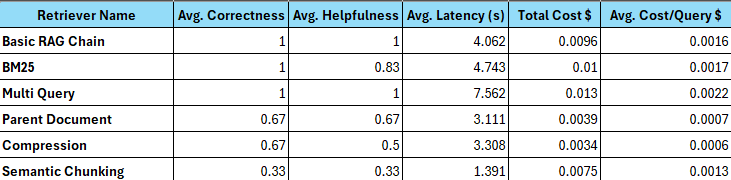


</div>

For the full code walkthrough of creating golden data set, please see `2-SDG.ipynb`


For Basic Rag Chain: 
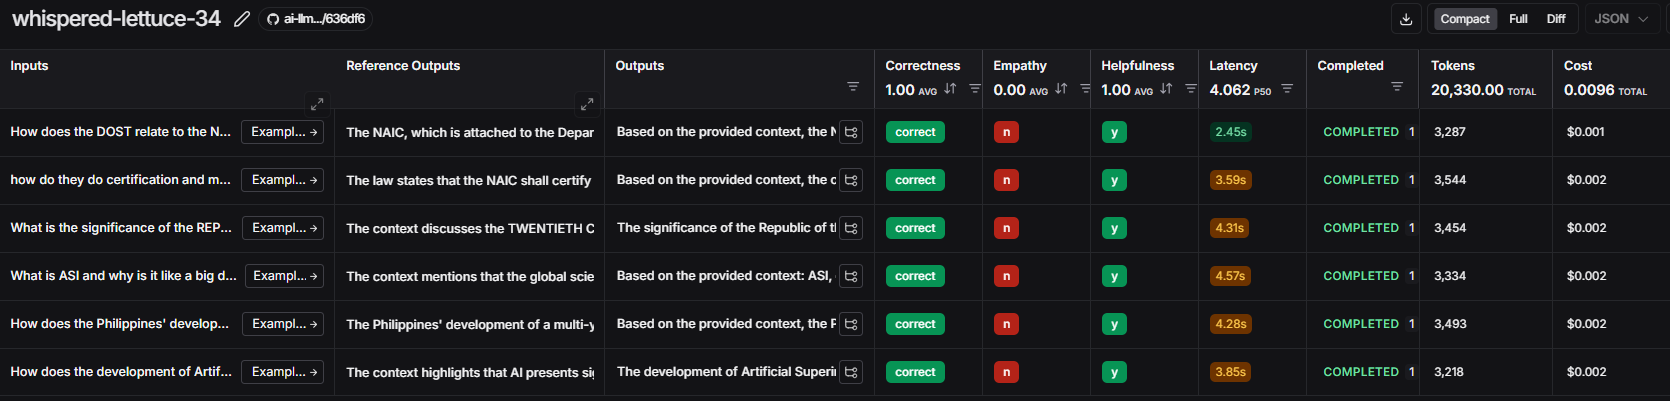

For BM25:
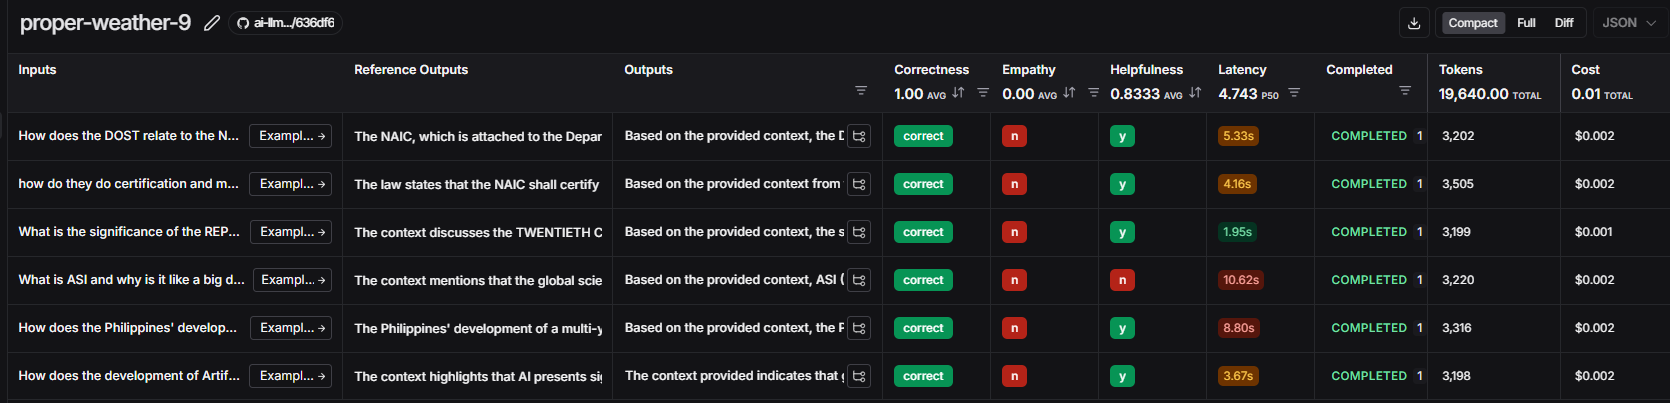

For Multi Query:
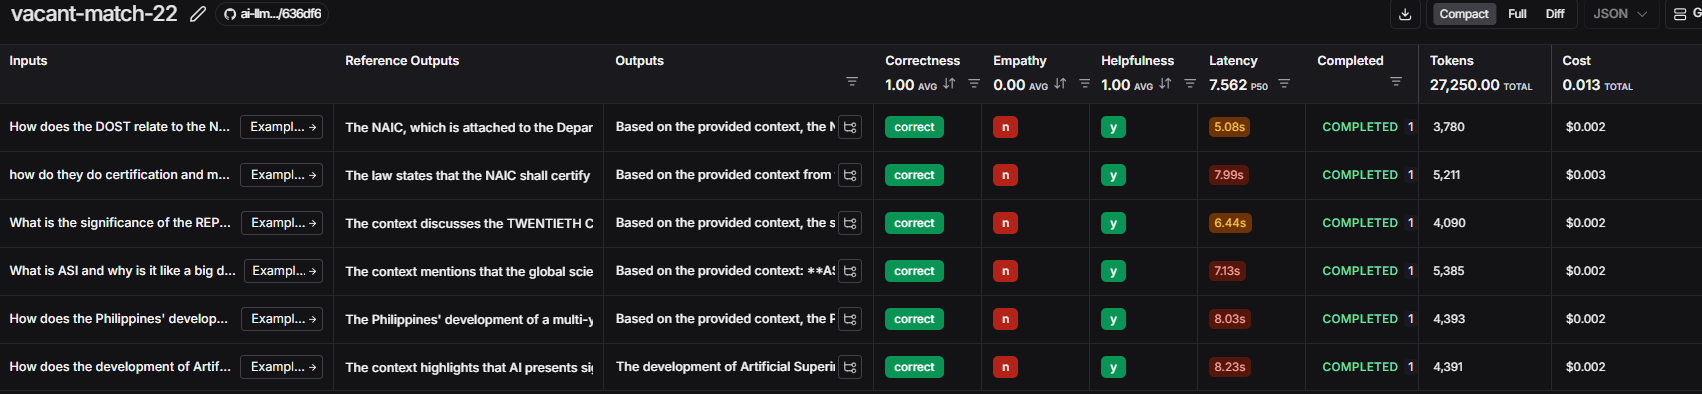

For Parent Document:
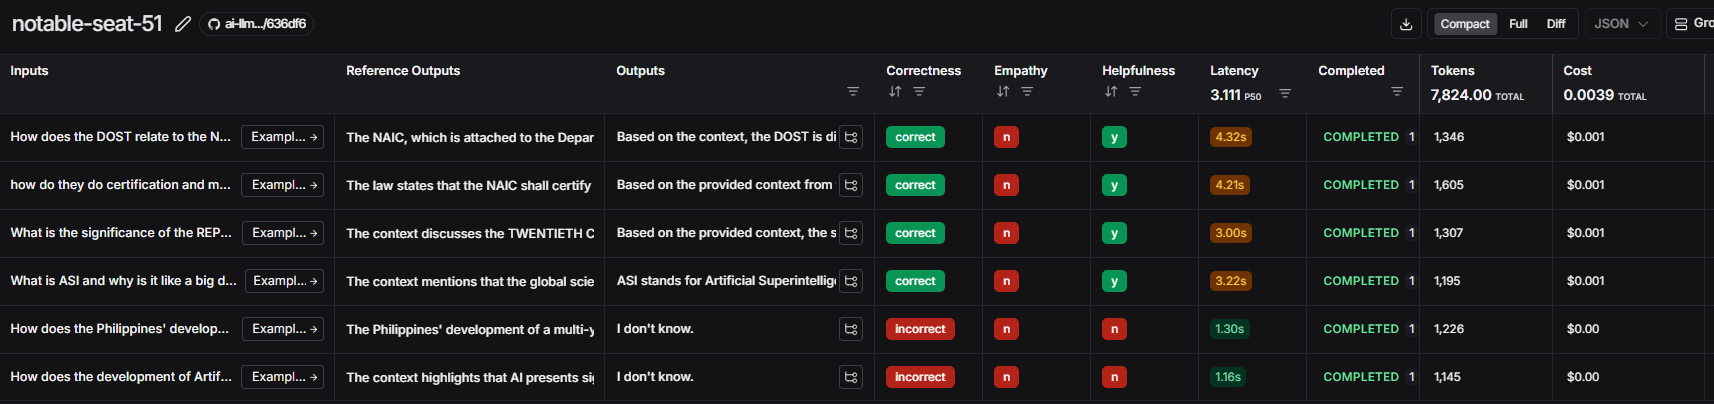

For Compression:
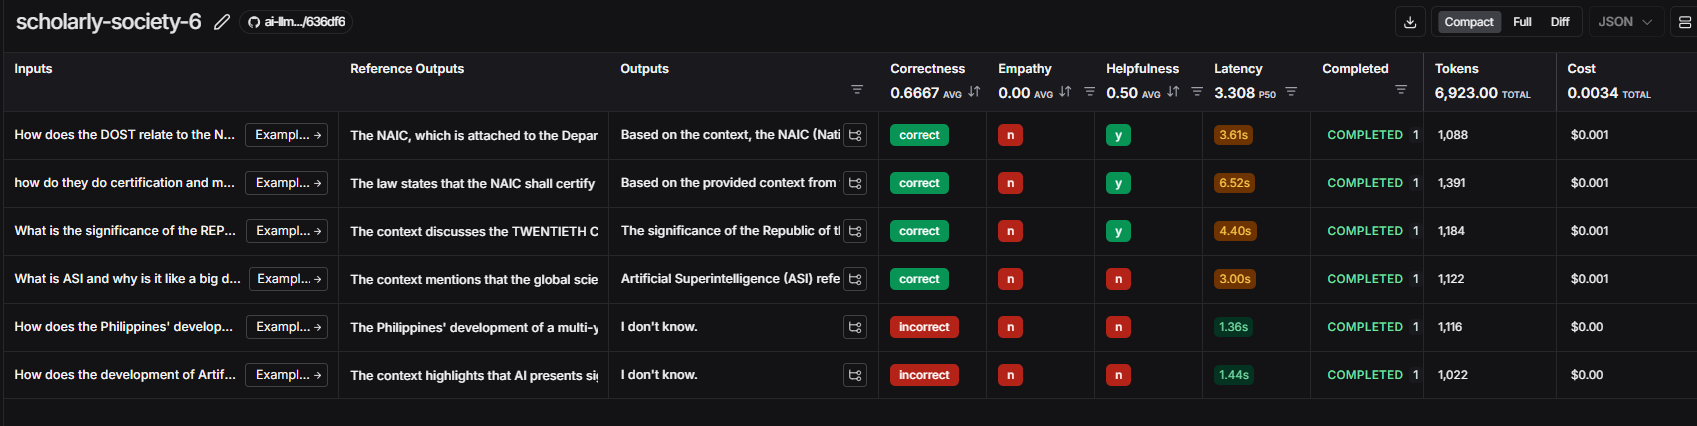

For Semantic Chunking:
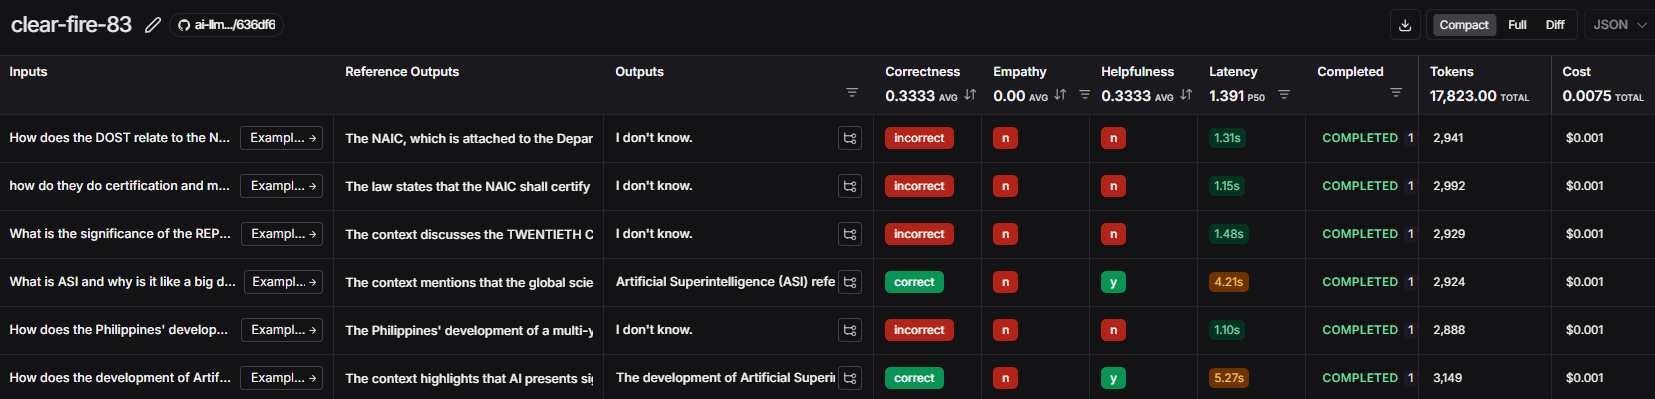